#                                          Loan Approval Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Load dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## Data Overview and Visualisation

In [3]:
train_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test_df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
test_df.duplicated().value_counts()

False    39098
Name: count, dtype: int64

In [6]:
train_df.duplicated().value_counts()

False    58645
Name: count, dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

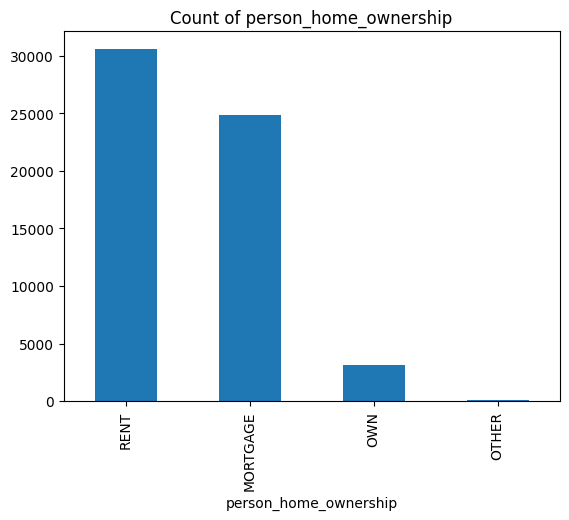

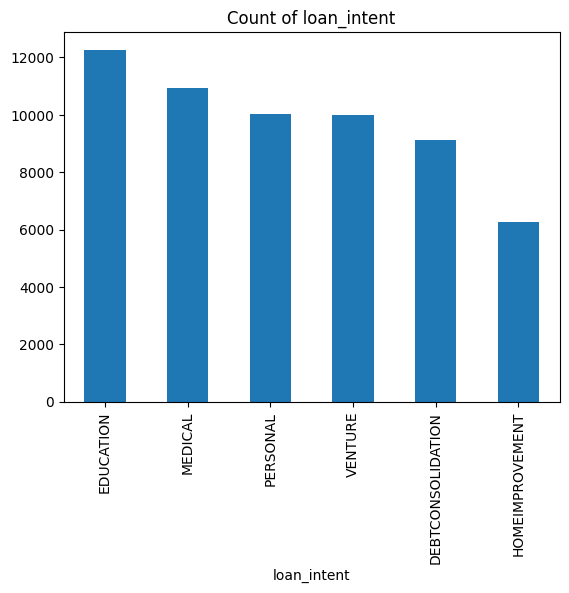

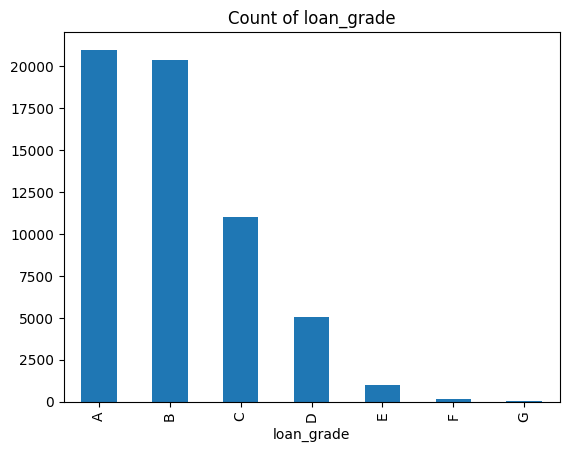

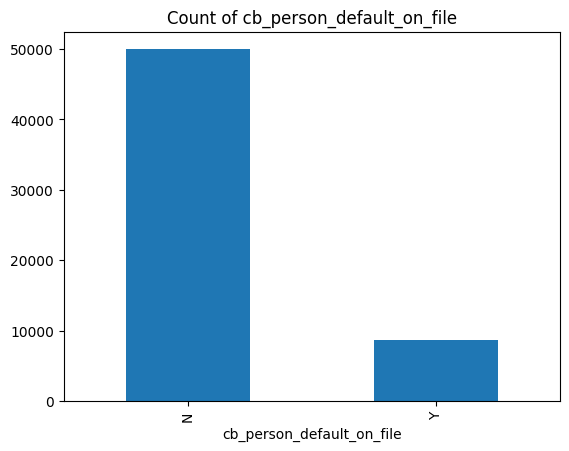

In [8]:
columns = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']

for i in columns:
    train_df[i].value_counts().plot(kind='bar')
    plt.title(f'Count of {i}')
    plt.show()

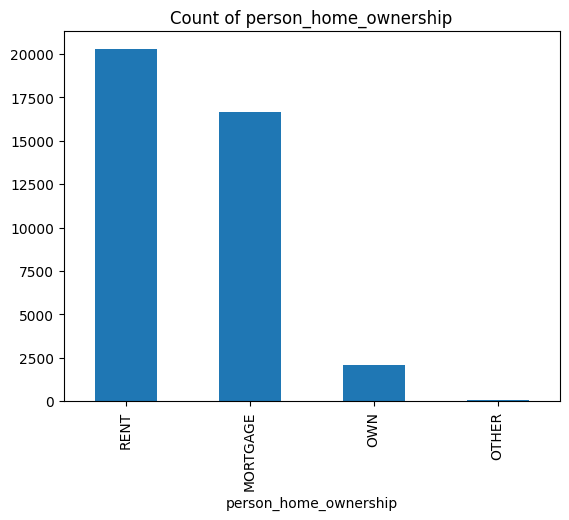

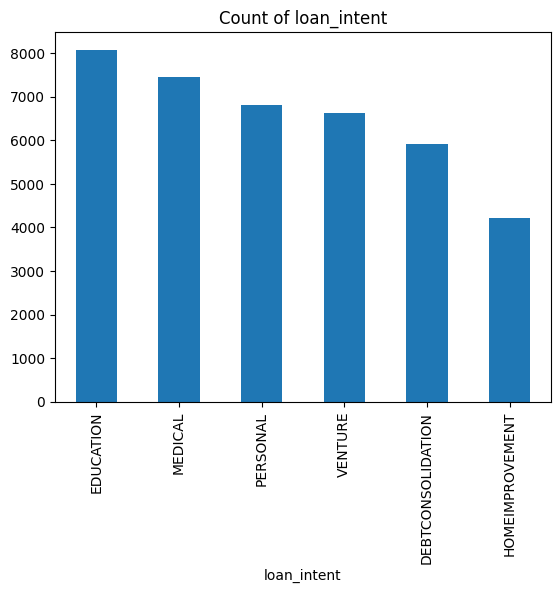

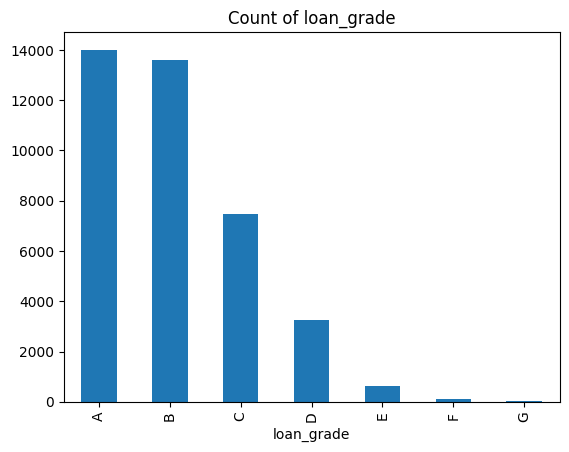

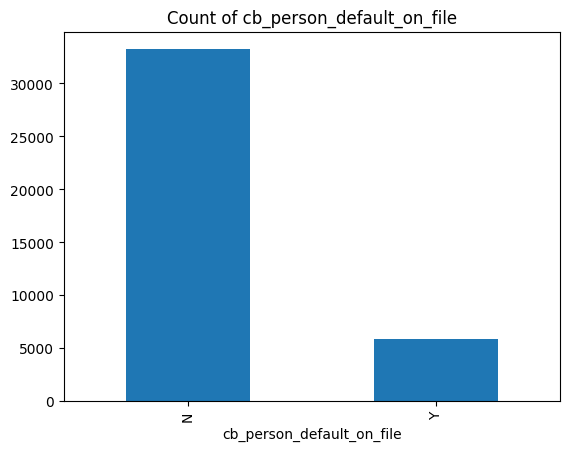

In [9]:
for i in columns:
    test_df[i].value_counts().plot(kind='bar')
    plt.title(f'Count of {i}')
    plt.show()

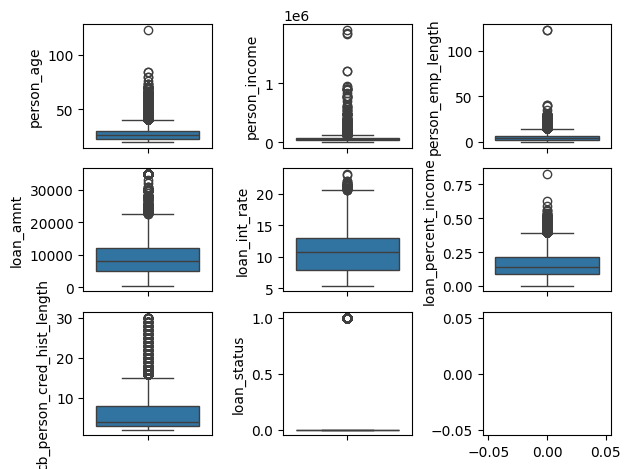

In [10]:
# Boxplot for outlier detection

t = 1
for i in train_df.select_dtypes(include='number').columns:
    sns.boxplot(train_df[i])
    plt.subplot(3,3,t)
    t+=1
    plt.plot()
plt.tight_layout()

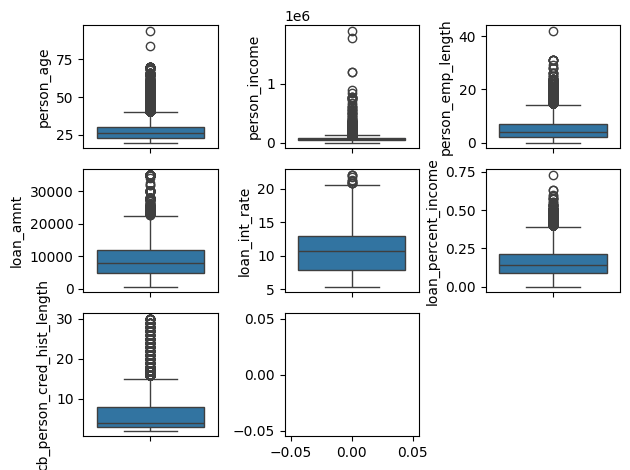

In [11]:
# Boxplot for outlier detection
t = 1
for i in test_df.select_dtypes(include='number').columns:
    sns.boxplot(test_df[i])
    plt.subplot(3,3,t)
    t+=1
    plt.plot()
plt.tight_layout()

### Inferences from the Dataset
1. **Outliers in Numeric Columns**:
   - The numeric columns have outliers present in both train and test datasets.

2. **No Duplicates**:
   - There are no duplicates in the datasets.

3. **Housing Status**:
   - Most of the people are living in rented houses, followed by mortgaged houses.

4. **Loan Purpose**:
   - Most of the people are taking loans for education, followed by medical and then personal loans.
   - Education and medical loans being the most common may suggest a trend towards borrowing for essential needs.

5. **Loan Grade**:
   - Most of the people are taking A-grade loans.


## Feature Engineering

In [12]:
# Data Preprocessing

# Drop rows with missing target values in 'loan_status'
train_df.dropna(subset=['loan_status'], inplace=True)

# Fill missing values for other columns in train and test datasets
train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

In [13]:
# Remove outliers using the IQR method for numerical columns
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

for col in numerical_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]

In [14]:
# Encode categorical columns
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le


In [15]:
# Scale numerical features
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])


## Data Modeling

In [16]:
# Define features and target variable
X = train_df.drop(columns=['id', 'loan_status'])
y = train_df['loan_status']

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Initialize and train the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Validate the model
val_predictions = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9489021136876667


In [ ]:
# Prediction on Test Data

# Prepare test data by removing ID column
X_test = test_df.drop(columns=['id'])
test_predictions = rf_clf.predict(X_test)

# Convert predictions to a DataFrame with IDs
submission_df = pd.DataFrame({'id': test_df['id'], 'loan_status': test_predictions})
submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")